In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [ ]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_in = os.path.join(pth_data, 'modeling', 'landscape')
pth_out = os.path.join(pth, 'figures', 'CCCA')

In [3]:
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
src_dict = df.Name.to_dict()

In [4]:
# load data
adata_dev = sc.read_h5ad(os.path.join(pth_in, 'development.h5ad'))
adata_dev = adata_dev[adata_dev.obs.landscape == 'True'].copy()
adata_3ca = sc.read_h5ad(os.path.join(pth_in, 'CCCA.h5ad'))
adata = adata_3ca[adata_3ca.obs.landscape == 'True'].copy()

In [5]:
# nearest-neighbor classifier (k = 1)
dims = ['X_mesen1', 'X_mesen2']
X_train = adata_dev.obs[dims].values.copy()
X_test = adata.obs[dims].values.copy()
scale = np.ptp(X_train, axis = 0)
X_train = X_train[np.newaxis, :, :] / scale
X_test = X_test[:, np.newaxis, :] / scale
d = np.linalg.norm(X_test - X_train, axis = 2)
y_train = adata_dev.obs.source.values
y_test = y_train[d.argmin(axis = 1)]

In [6]:
names_dict = {
    '../../data/unzip/CCCA/Data_Filbin2018_Brain'           : 'Pediatric H3-K27M Mutant Glioma',
    '../../data/unzip/CCCA/Data_Gojo2020_Brain'             : 'Pediatric Ependymoma',
    '../../data/unzip/CCCA/Data_He2021_Prostate'            : 'Metastatic Prostate Cancer',
    '../../data/unzip/CCCA/Data_Hovestadt2019_Brain'        : 'Medulloblastoma',
    '../../data/unzip/CCCA/Data_Jerby-Arnon2018_Skin'       : 'Melanoma',
    '../../data/unzip/CCCA/Data_Karaayvas2018_Breast'       : 'Triple-Negative Breast Cancer',
    '../../data/unzip/CCCA/Data_Maynard2020_Lung'           : 'Metastatic Non-Small Cell Lung Cancer',
    '../../data/unzip/CCCA/Data_Neftel2019_Brain/SmartSeq2' : 'Glioblastoma',
    '../../data/unzip/CCCA/Data_Puram2017_Head-and-Neck'    : 'Head and Neck Squamous Cell Carcinoma',
    '../../data/unzip/CCCA/Data_Tirosh2016_Brain'           : 'IDH-Mutant Oligodendroglioma',
    '../../data/unzip/CCCA/Data_Venteicher2017_Brain'       : 'IDH-Mutant Astrocytoma'}

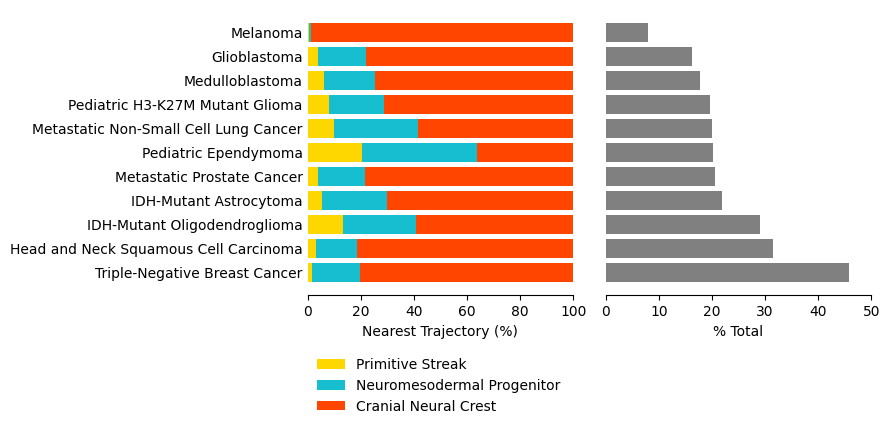

In [7]:
# plot classifier results
fig, ax = plt.subplots(
    ncols = 2,
    figsize = (9, 4.5),
    sharey = True)

df_clf = pd.crosstab(
    adata.obs.source,
    y_test,
    normalize = 'index')

df_tot = pd.crosstab(
    adata_3ca.obs.source,
    adata_3ca.obs.landscape,
    normalize = 'index')['True']

df_clf.columns = df_clf.columns.map(src_dict)
df_plt = pd.concat((df_clf, df_tot), axis = 1, join = 'inner')
df_plt = df_plt.mul(100).sort_values('True', ascending = False)
df_plt.index = df_plt.index.map(names_dict)

cdict = {
    'Primitive Streak'           : 'gold',
    'Neuromesodermal Progenitor' : 'tab:cyan',
    'Cranial Neural Crest'       : 'orangered'}

# nearest trajectory
left = pd.Series(0, index = df_plt.index)
for col in df_clf.columns:
    ax[0].barh(
        df_plt.index,
        df_plt[col],
        left = left,
        label = col,
        color = cdict[col])
    left += df_plt[col]
ax[0].set_xlim(0, 100)
ax[0].set_xlabel('Nearest Trajectory (%)')
ax[0].tick_params('y', size = 0)

# % total
ax[1].barh(df_plt.index, df_plt['True'], color = 'gray')
ax[1].set_xlim(0, 50)
ax[1].set_xlabel('% Total')
ax[1].tick_params(left = False)

for loc in ('top', 'right', 'left'):
    for i in np.arange(2):
        ax[i].spines[loc].set_visible(False)

ax[0].legend(bbox_to_anchor = (1, -.175), frameon = False)
fig.tight_layout()
fn = os.path.join(pth_out, 'classification.pdf')
plt.savefig(fn, bbox_inches = 'tight')